# DEM Download, Co-Registration, and Differencing for Geodetic Glacier Mass Balance Analysis 

### This Python workflow will walk you through the steps to: 

1. Pull the SRTM DEM corresponding to your study area from EarthAccess -OR- manually load an existing reference DEM of your choosing 
2. Load the additional DEM(s) you wish to co-register and the glacier polygons of your choosing (RGI, GLIMS, DGA, etc.)  
3. Reproject and resample DEMs to your chosen reference DEM (here SRTM, 30x30m resolution)
4. Perform DEM co-registration, following the workflow of Shean et al. (2023), an implementation of Nuth and Kääb (2011)
5. Clip the co-registered DEMs to glacier area 
6. Difference the DEMs to compute volume loss within glacier area 
7. Calculate geodetic glacier mass balance 
8. Produce figures  

This workflow has the following requirements: 
- a NASA EarthData login to download the SRTM elevation data. EarthData can be accessed at the following link: (https://urs.earthdata.nasa.gov/oauth/authorize?client_id=ZAQpxSrQNpk342OR77kisA&response_type=code&redirect_uri=https://appeears.earthdatacloud.nasa.gov/login&state=/)
- additional DEMs of the study area (e.g. UAV or satellite-derived product)

We use `earthaccess`, an open source package developed by Luis Lopez to download NASA data collections. It requires authentication using Earthdata Login credentials. See [https://github.com/nsidc/earthaccess](https://github.com/nsidc/earthaccess).

The workflow for Shean et al. (2023) DEM co-registration is found here: https://github.com/dshean/demcoreg

MS note to self: 
to activate virtual environment locally (in terminal): 


cd ~/Glacier-DEM-coregistration-and-MB

conda activate glacier-env

In [1]:
# Import required packages
import argparse
import os
import subprocess
import sys
import zipfile

# import earthaccess
import folium
from folium.raster_layers import ImageOverlay
import geopandas as gpd
from osgeo import gdal
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import CRS
import rioxarray as rxr
import xarray as xr

## Step 1: Pull SRTM for study area as reference DEM 

In [ ]:
# #Code to download SRTM DEM from EarthAccess

# # Enter your EarthAccess login and password 
# earthaccess.login()

# # search for SRTM data
# query = earthaccess.search_datasets(
#             keyword="SRTM",
# )

# bounding_box = (-71.4, -36.8, -71.2, -36.6) #update the bounding box for your study area 
# #  bbox is defined as [min_lon, min_lat, max_lon, max_lat]

# results = earthaccess.search_data(
#     short_name = 'SRTMGL1', # SRTM 1-arcsecond Global dataset (confirm this is the right SRTM dataset...)
#     cloud_hosted = True, # Ensure access to cloud-stored data
#     bounding_box=bounding_box
# )

# # Define output directory
# output_dir = "./srtm_data"
# os.makedirs(output_dir, exist_ok=True)

# # Download the files
# for granule in results:
#     earthaccess.download(granule, output_dir)

# ## add step / print statement to confirm download and confirm that the bounding box is the correct study area?? 
# print(f"Downloaded {len(results)} SRTM DEM files to: {os.path.abspath(output_dir)}")

# # Print study area bounding box
# print(f"Study area bounding box: {bounding_box}")  

/Users/milliespencer/Library/Python/3.10/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Authentication with Earthdata Login failed with:
{"error":"invalid_header","error_description":"Invalid header"}


LoginAttemptFailure: Authentication with Earthdata Login failed with:
{"error":"invalid_header","error_description":"Invalid header"}

## Unzip the SRTM download(s)


In [ ]:
# # Define the path to the zip file and the extraction directory
# zip_file = "/Users/milliespencer/Glacier-DEM-coregistration-and-MB/srtm_data/N58W134.SRTMGL1.hgt.zip"
# extracted_dir = "/Users/milliespencer/Glacier-DEM-coregistration-and-MB/srtm_data/"

# # Unzip the file
# with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#     zip_ref.extractall(extracted_dir)

# print(f"File unzipped to: {extracted_dir}")

File unzipped to: /Users/milliespencer/Glacier-DEM-coregistration-and-MB/srtm_data/


## Visualize the DEM to confirm

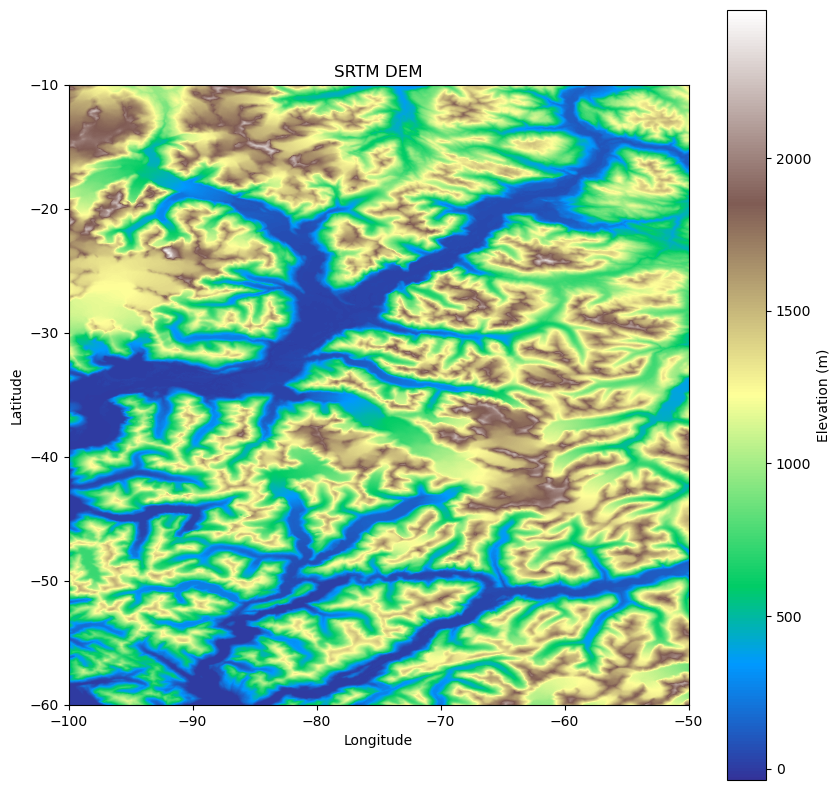

In [ ]:
# #Once the file is unzipped, read the .hgt file using rasterio:
# import matplotlib.pyplot as plt

# # Define the path to the unzipped DEM file
# dem_file = "/Users/milliespencer/Glacier-DEM-coregistration-and-MB/srtm_data/N58W134.hgt"

# # Open the DEM file using rasterio
# with rasterio.open(dem_file) as src:
#     dem_data = src.read(1)  # Read the first band (DEM data)
#     dem_transform = src.transform  # Get the spatial transform

# # Plot the DEM using matplotlib
# plt.figure(figsize=(10, 10))
# plt.imshow(dem_data, cmap='terrain', extent=[-75, -65, -40, -20])  # Adjust the extent to cover Chile
# plt.colorbar(label='Elevation (m)')
# plt.title('SRTM DEM')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

## Plot DEM over map of Chile to confirm location
 * for some reason the DEM is the size of the Americas lol, any ideas? tried to troubleshoot but can't correct

/Users/milliespencer/miniconda3/envs/oggm_env/lib/python3.12/site-packages/branca/colormap.py:98: RuntimeWarning: overflow encountered in scalar multiply
  float(self.vmin + (self.vmax - self.vmin) * k / 499.0) for k in range(500)



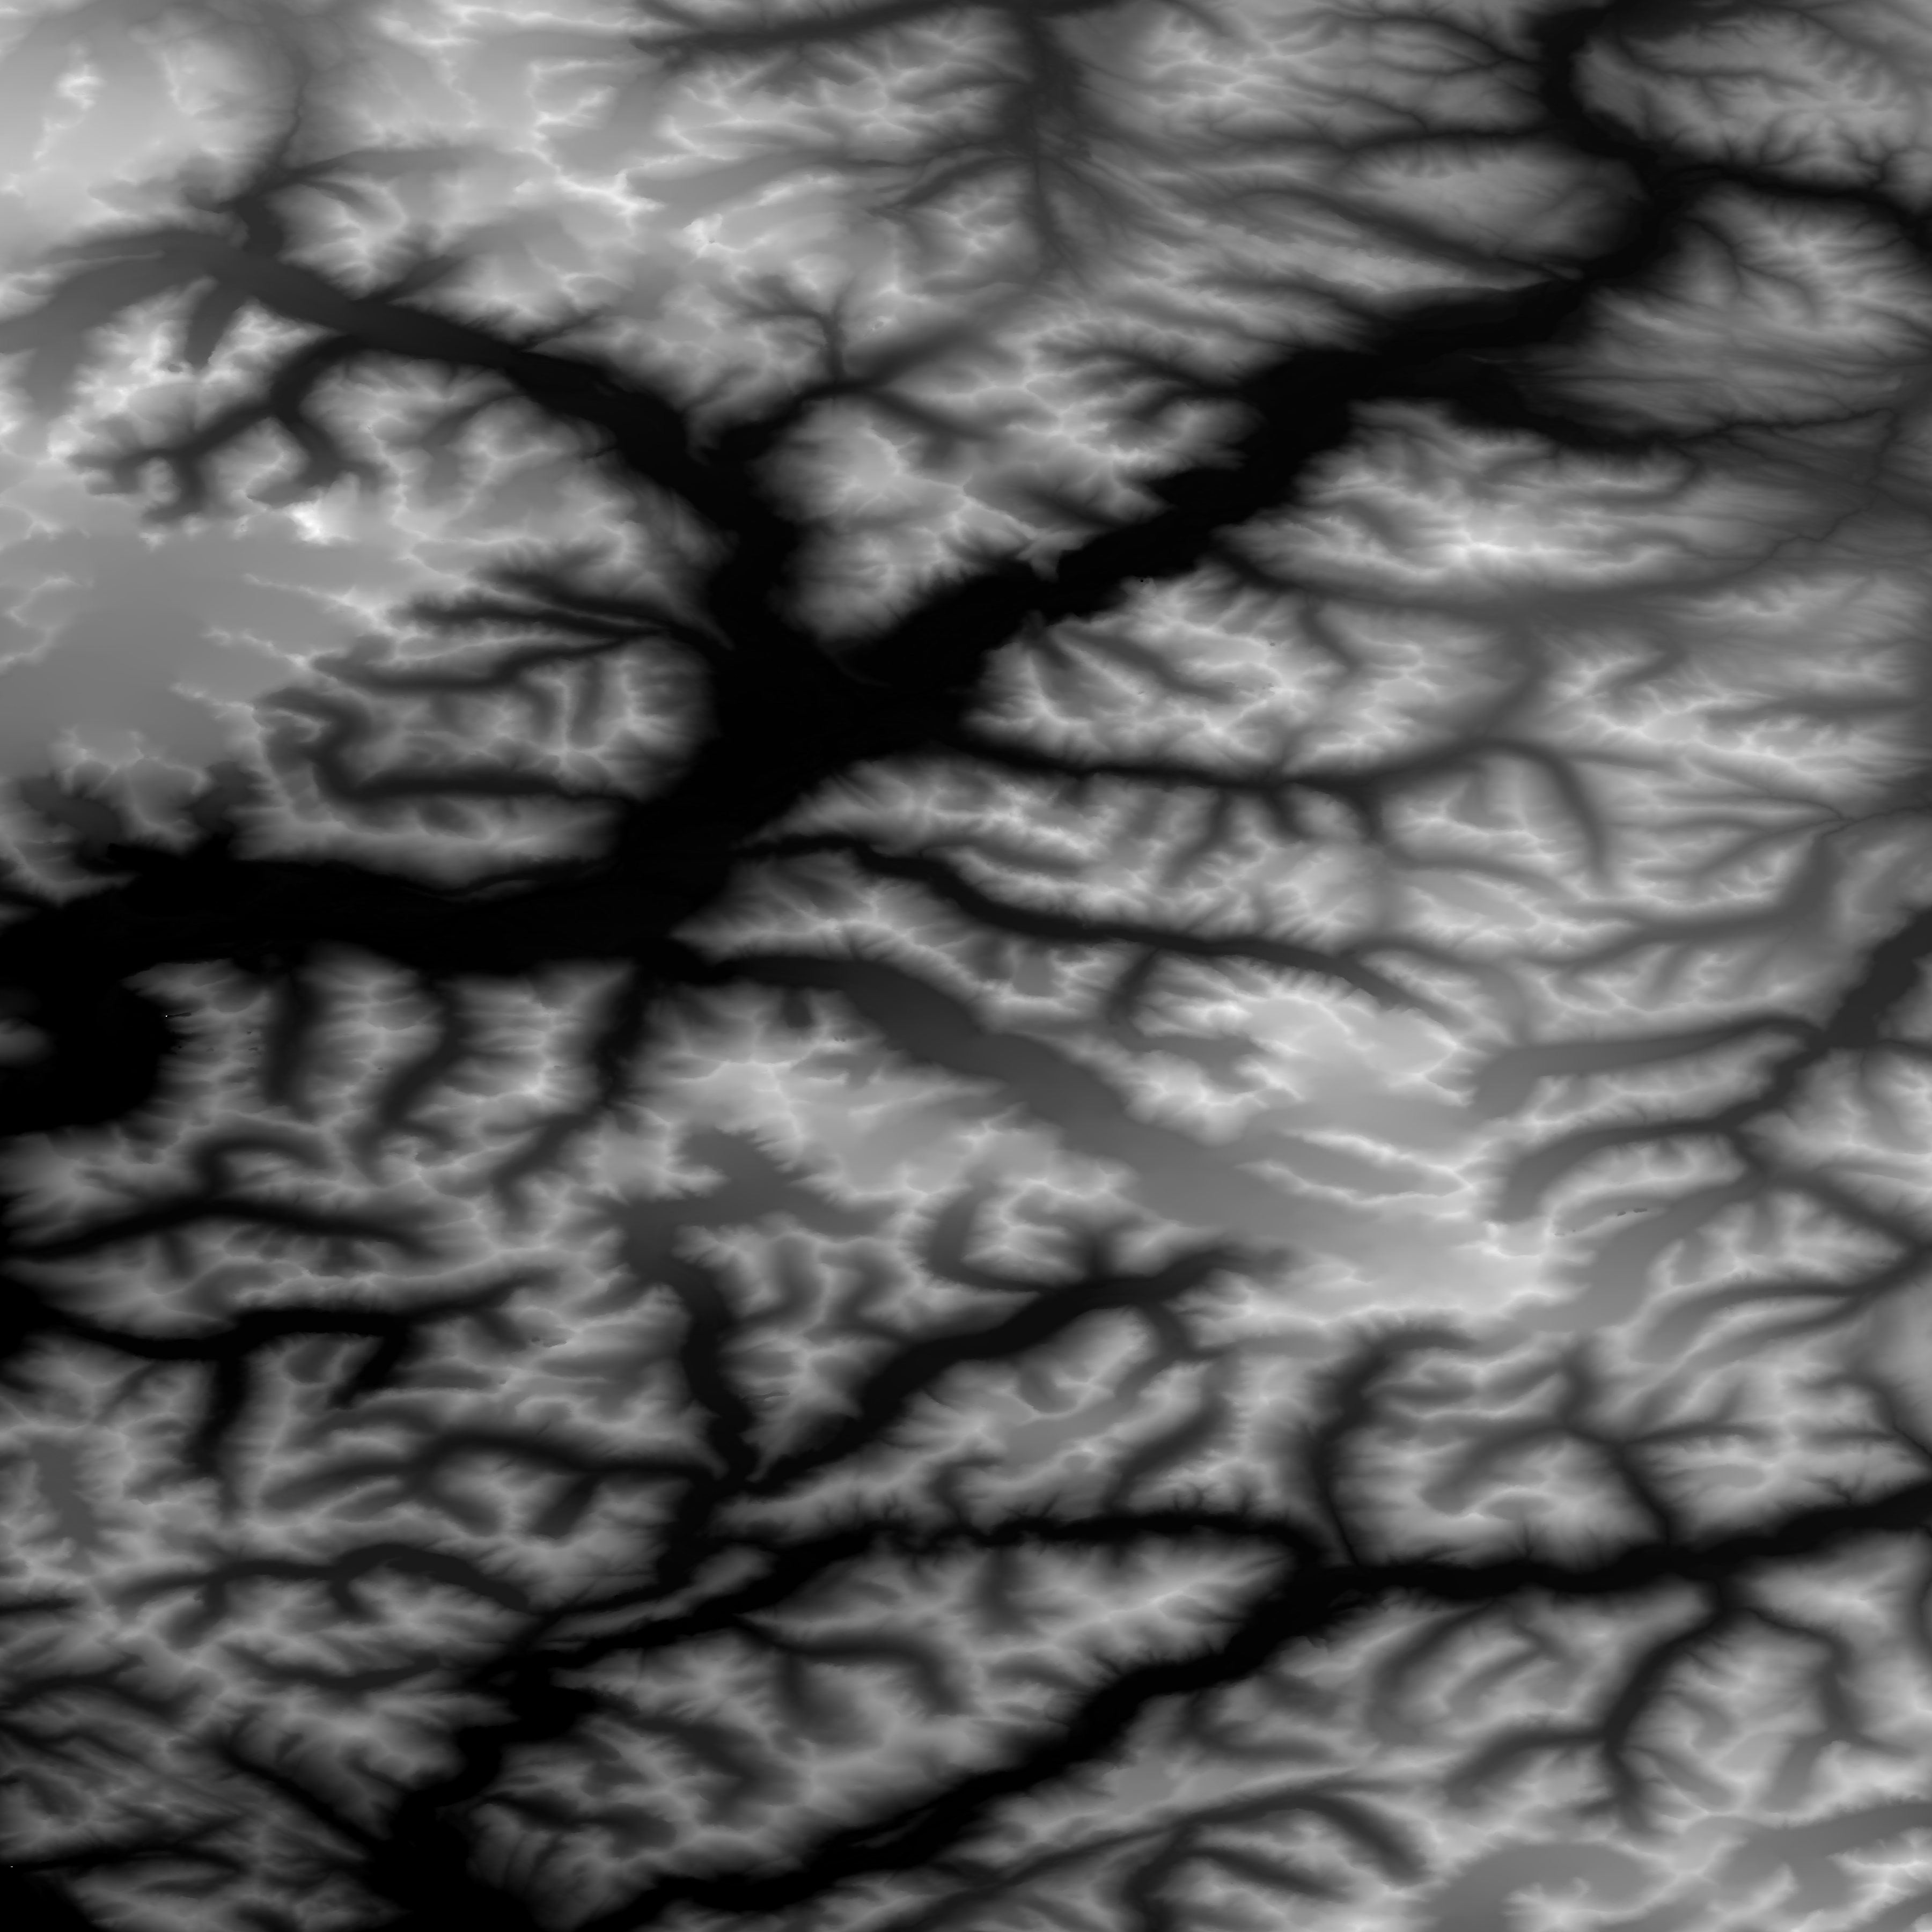

In [ ]:
# # Path to the SRTM DEM
# dem_file = "/Users/milliespencer/Glacier-DEM-coregistration-and-MB/srtm_data/N58W134.SRTMGL1.hgt.zip"

# # Open the DEM file using rasterio
# with rasterio.open(dem_file) as src:
#     dem_data = src.read(1)  # Read the DEM as a 2D numpy array
#     dem_transform = src.transform  # Get the affine transform
#     dem_crs = src.crs  # The CRS of the DEM
#     dem_bounds = src.bounds  # Get the bounds of the DEM

# # Check if the DEM is in EPSG:4326, otherwise we need to reproject it
# if dem_crs != CRS.from_epsg(4326):
#     print("Reprojecting DEM to EPSG:4326")
#     # Reproject the DEM to EPSG:4326 (WGS 84)
#     transform, width, height = calculate_default_transform(
#         dem_crs, CRS.from_epsg(4326), src.width, src.height, *dem_bounds
#     )
#     dem_data_reprojected = np.empty((height, width), dtype=rasterio.float32)
#     reproject(
#         source=src.read(1),
#         destination=dem_data_reprojected,
#         src_transform=dem_transform,
#         src_crs=dem_crs,
#         dst_transform=transform,
#         dst_crs=CRS.from_epsg(4326),
#         resampling=rasterio.enums.Resampling.nearest
#     )
# else:
#     dem_data_reprojected = dem_data

# # Normalize the DEM data to [0, 255] for display
# dem_data_normalized = np.clip(dem_data_reprojected, 0, 255)  # Ensure all values are within range
# dem_data_normalized = dem_data_normalized.astype(np.uint8)  # Convert to 8-bit for visualization

# # Set the bounds for the image overlay (in lat, lon)
# north, south, east, west = dem_bounds
# bounds = [[south, west], [north, east]]

# # Create the folium map centered around Chile (this is the central lat/lon for Chile)
# m = folium.Map(location=[-33.46, -70.65], zoom_start=5)  # Coordinates of Chile's capital (Santiago)

# # Overlay the DEM on the map
# ImageOverlay(
#     image=dem_data_reprojected,  # The DEM image data
#     bounds=bounds,  # The bounds for the overlay
#     # opacity=0.6,  # Set opacity to visualize the underlying map
# ).add_to(m)

# # Add a color scale to represent the elevation values
# from branca.colormap import linear
# colormap = linear.YlGnBu_09.scale(dem_data_reprojected.min(), dem_data_reprojected.max())
# colormap.add_to(m)

# # Save the map to an HTML file
# m.save('dem_map_corrected.html')

# # Display the map (you can open 'dem_map_corrected.html' in your browser)
# m

## Step 2a: Load the glacier shapefiles and the additional DEMs you wish to work with 

Below is the code to unzip Chilean glacier inventory shapefiles (DGA,2000 or DGA,2019) OR use unzipped example shapefiles for Nevados de Chillán complex. If your study area is outside of Chile, you can download glacier polygons for your study area from GLIMS here: https://www.glims.org/maps/glims and manually upload below. 

In [4]:
# comment out code that doesn't apply depending on which glacier polygon source you choose

# # if using example DGA shapefiles (unzipped) for Nevados de Chillán (one for the year 2000 and one for 2019)
glacier_area_2000_path = "example_data_Nevados/Nevados_glacier_shapefiles/Nevados_shapefile_DGA2000/Nevados_polygons_DGA2000.shp"
glacier_area_2019_path = "example_data_Nevados/Nevados_glacier_shapefiles/Nevados_shapefile_DGA2019/Nevados_polygons_DGA2019.shp"

# Load the shapefiles
glacier_2000_gdf = gpd.read_file(glacier_area_2000_path)
glacier_2019_gdf = gpd.read_file(glacier_area_2019_path)

# Display the first few rows
print(glacier_2000_gdf.head())
print(glacier_2019_gdf.head())


   Id      COD_GLA NOMBRE             CLASIFICA  REGION    COMUNA   DATUM  \
0  10  CL108130010    S/N  GLACIAR DE MONTAï¿½A  BIOBIO     PINTO  WGS 84   
1   3  CL108100003    S/N            GLACIARETE  BIOBIO  COIHUECO  WGS 84   
2   2  CL108100002    S/N            GLACIARETE  BIOBIO  COIHUECO  WGS 84   
3   4  CL108100004    S/N            GLACIARETE  BIOBIO  COIHUECO  WGS 84   
4   8  CL108130008    S/N            GLACIARETE  BIOBIO     PINTO  WGS 84   

    HUSO    ESTE    NORTE  ... ORIENABLAC ORIENTA CLAS_WGI  \
0  19SUR  288487  5915779  ...       None       S        6   
1  19SUR  288834  5916614  ...       None       N        7   
2  19SUR  289865  5916798  ...       None       E        7   
3  19SUR  288355  5916959  ...       None       E        7   
4  19SUR  287662  5916667  ...       None      SW        7   

             CLAS_2_CUB  ZONA_GLACI HMEDIANA PENDIENTE ERROR_KM2 ERROR_PORC  \
0  GLACIAR DE MONTAï¿½A    ZONA SUR   2907.0   26.7534  0.026888    19.3442   
1     

## Step 2b: Load the additional DEMs you wish to work with 

As an example, we provide an SRTM DEM, a DEM produced by 1954 Chilean military flights (IGM_1954), and two DEMs derived from uncrewed aerial vehicle (UAV) flights over Nevados de Chillán in March, 2024 (CerroBlanco and LasTermas). You can manually upload your DEMs to the same folder or route to a local file on your computer. Alternatively, you can modify the code in Step 1 to pull other DEM products from online platforms (e.g. IceSAT/-2, ArcticDEM, etc.). 

We also provide the GLIMS polygons in raster format ... 

In [ ]:
## code to call all DEMs at once 

# Path to your data folder
DEM_folder = "/Users/milliespencer/Glacier-DEM-coregistration-and-MB/example_data_Nevados/Nevados_DEMs"

# List of DEM filenames
dem_files = [
    "CerroBlanco_2024.tif",
    "LasTermas_2024.tif",
    "SRTM_2000.tif",
    "IGM_1954.tif"
] # CRS = EPSG:20049, DEM resolutions = 30m

# Dictionary to hold opened DEM datasets
dem_datasets = {}

# Loop to open all DEMs
for dem_file in dem_files:
    file_path = os.path.join(DEM_folder, dem_file)
    dem_name = os.path.splitext(dem_file)[0]  # Remove .tif extension
    dem_datasets[dem_name] = rasterio.open(file_path)
    # dem_datasets[dem_name] = rasterio.open(file_path).read(1) 
    # #If you plan to read them into arrays immediately, you can add .read(1) inside the loop^


# Optional: print CRS of each DEM to confirm they’re loaded
for name, dataset in dem_datasets.items():
    print(f"{name}: CRS = {dataset.crs}, Resolution = {dataset.res}")

# You can later access each DEM like this: 
dem_datasets["SRTM_2000"]

# Load all DEMs into a dictionary
dems = {name: rxr.open_rasterio(path, masked=True).squeeze() for name, path in dem_datasets.items()}

CerroBlanco_2024: CRS = EPSG:4326, Resolution = (8.761960000002116e-07, 7.042859999999532e-07)
LasTermas_2024: CRS = EPSG:4326, Resolution = (1.8726799999998898e-06, 1.504369999999964e-06)
SRTM_2000: CRS = EPSG:20049, Resolution = (30.0, 30.0)
IGM_1954: CRS = EPSG:20049, Resolution = (30.0, 30.0)


<open DatasetReader name='/Users/milliespencer/Glacier-DEM-coregistration-and-MB/example_data_Nevados/Nevados_DEMs/SRTM_2000.tif' mode='r'>

## Reproject all DEMs to UTM 19S (EPSG:32719):

In [9]:
# EPSG for UTM Zone 19 South (WGS 84 / UTM 19S)
target_crs = "EPSG:32719"

# Reproject all DEMs
for name in dems:
    dems[name] = dems[name].rio.reproject(target_crs)

## Resample and snap 

In [ ]:
# Use SRTM as reference
reference = dems['SRTM_2000']

# Function to match resolution and grid (snapping) to reference
def resample_and_align_to_reference(dem_datasets, reference):
    return dem_datasets.rio.reproject_match(reference, resampling=Resampling.bilinear)

# Resample all to match SRTM_2000
for name in dems:
    if name != 'SRTM_2000':
        dems[name] = resample_and_align_to_reference(dems[name], reference)

In [11]:
output_folder = "aligned_dems"
os.makedirs(output_folder, exist_ok=True)

for name, dem_datasets in dems.items():
    dem_datasets.rio.to_raster(os.path.join(output_folder, f"{name}_aligned.tif"))

In [12]:
# confirm reprojection sucessful 

for name, dem_datasets in dems.items():
    print(f"{name} CRS: {dem_datasets.rio.crs}")

CerroBlanco_2024 CRS: EPSG:32719
LasTermas_2024 CRS: EPSG:32719
SRTM_2000 CRS: EPSG:32719
IGM_1954 CRS: EPSG:32719


## Step 3: Perfom DEM co-registration 
Here we follow the workflow provided by Shean et al. (2023), derived from the Nuth and Kääb (2011) method, here: https://github.com/dshean/demcoreg/blob/master/docs/beginners_doc.md

The code below references Shean's 'dem_align.py - robust raster DEM co-registration' script, which housed here in the coreg_directory

NB: users should confirm that the co-registration workflow has not been modified since the date of this code publication. 

In [ ]:
# not sure why these aren't working given that everything is installed in the coreg_directory... will come back to this tomorrow 
import pygeotools
import demcoreg
import imview

ModuleNotFoundError: No module named 'pygeotools'

### Co-registration setup: 
Loading the DEMs, reprojecting the DEMs to the same spatial reference system, extent, and cell size, and calculating slope and aspect to use in the co-registration process: